In [1]:
import scgen
import scanpy as sc
import pandas as pd
import numpy as np
from metrics import compute_entropy, silhouette_coeff_ASW

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

Running Scanpy 1.7.2, on 2021-06-17 13:53.


In [3]:
train_scgen = sc.read_h5ad('/media/bgi/zhouruilong/deepMNN/data/dataset5.h5ad')

train_scgen = train_scgen[(train_scgen.obs.batch != '0') | (train_scgen.obs.celltype != 'B cell')]
train_scgen = train_scgen[(train_scgen.obs.batch != '1') | (train_scgen.obs.celltype != 'NK cell')]
train_scgen = train_scgen[(train_scgen.obs.batch != '1') | (train_scgen.obs.celltype != 'Monocyte_CD14')]
train_scgen = train_scgen[(train_scgen.obs.batch != '0') | (train_scgen.obs.celltype != 'CD8 T cell')]

sc.pp.normalize_total(train_scgen)
sc.pp.log1p(train_scgen)
sc.pp.highly_variable_genes(train_scgen, n_top_genes=7000)
train_scgen = train_scgen[:,train_scgen.var.highly_variable]

/media/bgi/zhouruilong/anaconda3/envs/scGen/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [4]:
train_scgen.obs["cell_type"] = train_scgen.obs["celltype"].tolist()

Trying to set attribute `.obs` of view, copying.


In [5]:
train_scgen = scgen.setup_anndata(train_scgen, batch_key="batch", labels_key="cell_type",  copy=True)

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 9735 cells, 7000 vars, 2 batches, 
         9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [6]:
model = scgen.SCGEN(train_scgen)

/media/bgi/zhouruilong/anaconda3/envs/scGen/lib/python3.7/site-packages/scvi/model/base/_base_model.py:148: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


In [7]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    use_gpu=True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 28/100:  28%|██▊       | 28/100 [02:21<06:03,  5.05s/it, loss=93.6, v_num=1]


In [8]:
adata_scgen = model.batch_removal()

adata_scgen.obsm['X_pca'] = adata_scgen.obsm['corrected_latent']
sc.pp.neighbors(adata_scgen)
sc.tl.umap(adata_scgen)

/media/bgi/zhouruilong/anaconda3/envs/scGen/lib/python3.7/site-packages/scvi/model/base/_base_model.py:148: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 9735 cells, 7000 vars, 2 batches, 
         9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/media/bgi/zhouruilong/anaconda3/envs/scGen/lib/python3.7/site-packages/scvi/model/base/_base_model.py:148: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."
computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:44)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'cell_type' as categorical


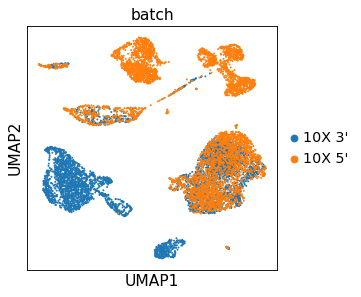

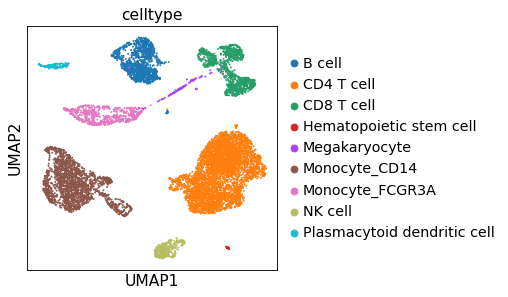

In [9]:
adata_scgen.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in adata_scgen.obs['batch']]
sc.pl.umap(adata_scgen,color='batch',save='_figure4_scgen_batch.pdf')
sc.pl.umap(adata_scgen,color='celltype',save='_figure4_scgen_celltype.pdf')

In [10]:
asw_scgen = silhouette_coeff_ASW(adata_scgen)
entropy_scgen = compute_entropy(adata_scgen)

Calculating entropy ...
use exist neighbors


/media/bgi/zhouruilong/deepMNN/Reproduction of result/scGen/metrics.py:53: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  knn_graph = adata.uns['neighbors']['connectivities']


Entropy calculated!


In [14]:
asw_scgen.to_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig4/asw_scgen_fig4.csv',index=0)
entropy_scgen.to_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig4/entropy_scgen_fig4.csv',index=0)

In [13]:
adata_scgen.write('/media/bgi/zhouruilong/deepMNN/processed_adata/adata_scgen_fig4.h5ad')